<a href="https://colab.research.google.com/github/saipragathi0912/Option-Pricing-using-Reinforcement-Learning/blob/main/Final_Option_Pricing_using_Reinforcement_Learning_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install QuantLib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 45.0 MB/s eta 0:00:00


In [ ]:
import QuantLib as ql
import datetime as dt
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt

In [ ]:
class OptionPricingEnv():
  def __init__(self,S0,T,X,R,option_type,sigma,today):
    """
      Constructor Definition:
        S0 - Value of the stock at time t = 0
        T - Expiration time of the stock in years
        R - Risk Free Rate
        Option Type - Call or Put
        X - Strike Price
        sigma = Risk or volatality of the market
    """
    self.S0 = S0
    self.T = T
    self.X = X
    self.R = R
    self.sigma = sigma
    self.option_type = option_type
    self.stock_price = S0
    self.state_path = [self.stock_price] # State Space Definition - Stock price at time t 
    self.actions = [0,1] # Action Space Definition - 0 for exercise and 1 for hold the option
    self.today = today
    self.time = 1

  def get_price_using_existing_model(self):
    years, remainder = divmod(self.time, 365)
    months, days = divmod(remainder, 30)
    maturity = ql.Date(self.today.day+days, self.today.month+months, self.T+self.today.year+years)
    S0 = self.S0
    K = self.X
    r = self.R
    sigma = self.sigma
    d =  0.0
    if self.option_type == 'Put':
      otype = ql.Option.Put
    else:
      otype = ql.Option.Call
    dc = ql.Actual365Fixed()
    calendar = ql.NullCalendar()
    payoff = ql.PlainVanillaPayoff(otype, K)
    today = ql.Date(self.today.day, self.today.month, self.today.year)
    ql.Settings.instance().evaluationDate = today
    american_exercise = ql.AmericanExercise(today, maturity)
    american_option = ql.VanillaOption(payoff, american_exercise)
    d_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, d, dc))
    r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, dc))
    sigma_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, calendar, sigma, dc))
    bsm_process = ql.BlackScholesMertonProcess(ql.QuoteHandle(ql.SimpleQuote(S0)), d_ts, r_ts, sigma_ts)
    binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", 100)
    american_option.setPricingEngine(binomial_engine)
    return american_option.NPV()

  def reset(self):
    self.time = 1
    self.S1 = self.S0
    time_elapsed = 1.0
    return [self.S1, time_elapsed]

  def step(self, action):
    if action == 1:  
        reward = max(self.X-self.S1, 0.0) * np.exp(-self.R * self.T * (self.time/(self.T*365)))
        done = True
    else:     
        if self.time == self.T*365: 
            reward = max(self.K-self.S1, 0.0) * np.exp(-self.R * self.T)
            done = True
        else: 
            reward = 0
            self.S1 = self.S1 * np.exp((self.R - 0.5 * self.sigma**2) * (self.T/(self.time)) + self.sigma * np.sqrt(self.T/self.time) * np.random.normal())
            self.time += 1
            done = False

    time_elapsed = 1.0-self.time/(self.T*365)   
    return np.array([self.S1, time_elapsed]), reward, done, {}


In [ ]:
# Define the deep Q-learning agent
class DQNAgent:
    def __init__(self, env, lr, gamma, epsilon):
        self.env = env
        self.lr = lr # Learning rate
        self.gamma = gamma # Discount factor
        self.epsilon = epsilon # Epsilon-greedy parameter
        self.q_network = tf.keras.Sequential([
            tf.keras.layers.Dense(32, input_shape=(2,), activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(len(env.actions), activation='linear')
        ])
        self.q_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                               loss='mse')
        self.replay_buffer = []
        self.batch_size = 32

    def update_replay_buffer(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    def get_action(self, state):
        if np.random.uniform() < self.epsilon:
            return np.random.randint(len(self.env.actions))
        else:
            try:
              q_values = self.q_network.predict(np.array([state]))
              return np.argmax(q_values)
            except:
              return 

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        batch = random.sample(self.replay_buffer, self.batch_size)
        states = []
        targets = []
        for state, action, reward, next_state, done in batch:
            q_values = self.q_network.predict(np.array([state]))
            if done:
                q_values[0][action] = reward
            else:
                next_q_values = self.q_network.predict(np.array([next_state]))
                print(np.array([next_state]).shape)
                q_values[0][action] = reward + self.gamma * np.max(next_q_values)
            states.append(state)
            targets.append(q_values[0])
        self.q_network.fit(np.array(states), np.array(targets), verbose=0)
        self.epsilon = max(0.01, self.epsilon * 0.99)

In [ ]:
env = OptionPricingEnv(S0=100,X=100,T=2,R=0.02,option_type='Call',sigma = 0.2,today=dt.date.today())
agent = DQNAgent(env,lr=0.2,gamma=1.0,epsilon=0.5)
rewards = []
for i in range(100):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.get_action(state)
        next_state, reward, done,info = env.step(action)
        agent.update_replay_buffer(state, action, reward, next_state, done)
        total_reward+=reward
        state = next_state
    print("Episode number ",i+1," Reward: ",total_reward)
    rewards.append(total_reward)
    agent.train()

Streaming output truncated to the last 5000 lines.
(1, 2)
1/1 [==============================] - 0s 28ms/step
(1, 2)
1/1 [==============================] - 0s 32ms/step
(1, 2)
1/1 [==============================] - 0s 34ms/step
(1, 2)
1/1 [==============================] - 0s 26ms/step
(1, 2)
1/1 [==============================] - 0s 26ms/step
(1, 2)
1/1 [==============================] - 0s 26ms/step
(1, 2)
1/1 [==============================] - 0s 19ms/step
Episode number  42  Reward:  34.781564153923554
1/1 [==============================] - 0s 19ms/step
(1, 2)
1/1 [==============================] - 0s 24ms/step
(1, 2)
1/1 [==============================] - 0s 18ms/step
(1, 2)
1/1 [==============================] - 0s 19ms/step
(1, 2)
1/1 [==============================] - 0s 22ms/step
(1, 2)
1/1 [==============================] - 0s 18ms/step
(1, 2)
1/1 [==============================] - 0s 19ms/step
(1, 2)
1/1 [==============================] - 0s 19ms/step
(1, 2)
1/1 [===========

In [ ]:
sum(rewards)/len(rewards)

9.11828685911373

In [ ]:
env.get_price_using_existing_model()

13.147669262764708

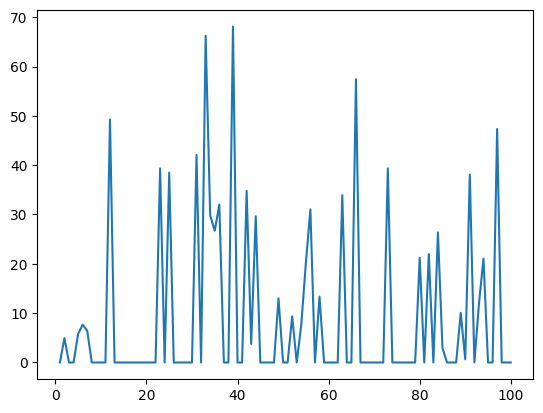

In [ ]:
num_episodes = np.arange(1,101,1)
plt.plot(num_episodes,rewards)